# Sentiment Analysis on Customer Reviews: Selection of the Best Feature Engineering and Machine Learning Models for Sentiment Prediction Problem
# ===========================================================

# Introduction

With the booming of online comments, the ability of predicting customer sentiments from the customer reviews becomes a prompt and practical need for enterprises of various sizes. 

This research aims to investigate the best combination of the feature engineering techniques on text and machine learning algorithms in predicting sentiment from customer reviews.

A large empirical dataset from online review platform Yelp was used. A total of 3 most popular feature engineering techniques on text and 2 most popular machine learning algorithms were used as base models. Then we attempted different ensemble methods to determine whether there were further improvements.

The feature engineering we used include Bag of Word (BOW), Term Frequency–Inverse Document Frequency (TF-IDF) and N-grams. The algorithms that we used include Logistic Regression and Support Vector Machines (SVM). The ensemble methods that we deployed include Bagging, Random Forest, Boosting and Stacking.


# Data Collection

## Data Source
The original dataset is from Yelp (https://www.yelp.com/dataset). It consists of the following sub-datasets in json format:

* **business.json**: Contains business data including location data, attributes, and categories.
* **review.json**: Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
* **user.json**: User data including the user's friend mapping and all the metadata associated with the user.
* **checkin.json**: Checkins on a business.
* **tip.json**: Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

In this project, we will mainly use the information in the business and review files.

The original review dataset has more than 6 million reviews. In order to select the reviews pertaining to Chinese restaurants, we performed the following filtering routine:

* Using the business dataset, obtain a list of business IDs which are Chinese restaurants by searching for key word "Chinese" in the business categories column.
* Under the review dataset, select the relevant reviews based on the list of business IDs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import collections
import re, string
import sys
import time
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# load business JSON file
business_df = pd.read_json("yelp_academic_dataset_business.json", lines=True)
print(business_df.head())
print(business_df.shape)

chinese_restaurants = business_df[business_df['categories'].str.contains('Chinese') == True]

print(chinese_restaurants.head())
print(chinese_restaurants.shape)

#chinese_restaurants.to_csv('chinese_business.csv')

               address                                         attributes  \
0    1314 44 Avenue NE  {'BikeParking': 'False', 'BusinessAcceptsCredi...   
1                       {'Alcohol': 'none', 'BikeParking': 'False', 'B...   
2  1335 rue Beaubien E  {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
3      211 W Monroe St                                               None   
4  2005 Alyth Place SE             {'BusinessAcceptsCreditCards': 'True'}   

              business_id                                         categories  \
0  Apn5Q_b6Nz61Tq4XzPdf9A  Tours, Breweries, Pizza, Restaurants, Food, Ho...   
1  AjEbIBw6ZFfln7ePHha9PA  Chicken Wings, Burgers, Caterers, Street Vendo...   
2  O8S5hYJ1SMc8fA4QBtVujA  Breakfast & Brunch, Restaurants, French, Sandw...   
3  bFzdJJ3wp3PZssNEsyU23g                      Insurance, Financial Services   
4  8USyCYqpScwiNEb58Bt6CA  Home & Garden, Nurseries & Gardening, Shopping...   

        city                                            

The code above shows that there are 4,468 Chinese restaurants. As for selecting the relevant reviews based on the business IDs for the 4,468 Chinese restaurants, because it is very computationally expensive, we extracted these reviews separately. Below is the relevant reviews in csv format.

In [3]:
# load Chinese restaurant review file
chinese_reviews_df = pd.read_csv("yelp_chinese_review.csv")
print(chinese_reviews_df.head())
print(chinese_reviews_df.shape)


   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      1  0pf5VuzE4_1pwj5NJHG5TQ  oyhOp2Eu7A9rsnmoV0VFgA   
2      0  0pf5VuzE4_1pwj5NJHG5TQ  8k2WpYJFfsPL3kupmvGjWA   
3      0  0pf5VuzE4_1pwj5NJHG5TQ  JvCsQXCkTkybpkJd8oSimw   
4      0  Yy_iGXxLpL6tYDQoE-6XVg  mqhCY5oLA1LXP6gZ3JQDTQ   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  Been coming here for years, always delicious f...  SVMR0kRmdd-bbSNTTECJBA   
2  Best place for dim sum in the valley.  Prefer ...  szhJLmdLDVFTevm8fu0T4A   
3  Love the house chicken and chicken fried rice....  A2pHOVp0zh7grb1bbZxoBQ   
4  The spicy wonton was my favorite. We ordered a...  JPfi__QJAaRzmfh5aOyFEw   

   stars        date  useful  cool  
0      5  2016-05-01       0     0  
1      5  2016-03-06       0     0  
2      5  2016-05-01       0     0  
3      4  

As we can see, the review dataset has been narrowed down from 6 million to 227,132 reviews.

## Prepare Review Dataset for Data Exploration

In order to perform effective data exploration, we are merging the business dataset with the review dataset.

In [4]:
chinese_reviews_df_full = pd.merge(chinese_reviews_df,right=business_df, how="inner",on='business_id')
chinese_reviews_df_full.rename(columns = {'stars_x': 'stars',
                                   'stars_y': 'stars_business',},inplace=True)
chinese_reviews_df_full.to_csv('yelp_chinese_review_full.csv')
print(chinese_reviews_df_full.head())
print(chinese_reviews_df_full.shape)

   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      0  ZuCXUnvBXN9wj2S8ZD40qw  0Z4uMWbCUKKtzDFeOoQt3Q   
2      0  NH7hMsA2Mogeboht1-XEVQ  AKTWTO0aUe8GMnax51aSjA   
3      0  o5hp_ni5e0SrCTczzEajuA  qrNDl6NDPS_4u8T5VJMx9g   
4      0  4SJbA5cVsHHVBt3bpGHTzg  HFFV71RDN0odsR1a7Bc9oA   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  getting some food I wish it was a lot bigger t...  OX0T9dWI8b7meu-ljTo22A   
2  The place is a pit and it always has been a pi...  OX0T9dWI8b7meu-ljTo22A   
3  I have been coming to long wongs for 10 years!...  OX0T9dWI8b7meu-ljTo22A   
4  For the most part it's a unique and different ...  OX0T9dWI8b7meu-ljTo22A   

   stars        date  useful  cool           address  ...   \
0      5  2016-05-01       0     0  2812 E Thomas Rd  ...    
1      4  2013-12-10       0     0

In [5]:
chinese_reviews_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227132 entries, 0 to 227131
Data columns (total 23 columns):
funny             227132 non-null int64
user_id           227132 non-null object
review_id         227132 non-null object
text              227132 non-null object
business_id       227132 non-null object
stars             227132 non-null int64
date              227132 non-null object
useful            227132 non-null int64
cool              227132 non-null int64
address           227132 non-null object
attributes        226711 non-null object
categories        227132 non-null object
city              227132 non-null object
hours             208215 non-null object
is_open           227132 non-null int64
latitude          227132 non-null float64
longitude         227132 non-null float64
name              227132 non-null object
neighborhood      227132 non-null object
postal_code       227132 non-null object
review_count      227132 non-null int64
stars_business    227132 non-nul

# Create the Sentiment Column

We are using a simple logic to create the sentiment colum based on the review ratings. If the ratings are greater than 3, the sentiment will be positive. If the rating score is less than 3, the sentiment will be negative. It's neutral if the rating is equal to 3.

In [6]:
# in df 'reviews', create a new column 'stars_norm', it = stars - stars_mean
#chinese_reviews_df_norm['stars_norm'] = chinese_reviews_df_norm['stars'] - chinese_reviews_df_norm['stars_mean']
# in df 'reviews', create a new column 'sentiment', based on whether stars_norm is >0, == 0 or <0
chinese_reviews_df_full['sentiment'] = np.where(chinese_reviews_df_full.stars > 3, 'positive', 
                        np.where(chinese_reviews_df_full.stars == 3, 'neutral', 'negative'))
print(chinese_reviews_df_full.head())
chinese_reviews_df_full.to_csv('chinese_reviews_df_full.csv')

   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      0  ZuCXUnvBXN9wj2S8ZD40qw  0Z4uMWbCUKKtzDFeOoQt3Q   
2      0  NH7hMsA2Mogeboht1-XEVQ  AKTWTO0aUe8GMnax51aSjA   
3      0  o5hp_ni5e0SrCTczzEajuA  qrNDl6NDPS_4u8T5VJMx9g   
4      0  4SJbA5cVsHHVBt3bpGHTzg  HFFV71RDN0odsR1a7Bc9oA   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  getting some food I wish it was a lot bigger t...  OX0T9dWI8b7meu-ljTo22A   
2  The place is a pit and it always has been a pi...  OX0T9dWI8b7meu-ljTo22A   
3  I have been coming to long wongs for 10 years!...  OX0T9dWI8b7meu-ljTo22A   
4  For the most part it's a unique and different ...  OX0T9dWI8b7meu-ljTo22A   

   stars        date  useful  cool           address    ...    is_open  \
0      5  2016-05-01       0     0  2812 E Thomas Rd    ...          1   
1      4  

# Data Exploration

## Overview of the Reviews

In [7]:
useful_reviews = len(chinese_reviews_df_full[chinese_reviews_df_full["useful"]>0])
cool_reviews = len(chinese_reviews_df_full[chinese_reviews_df_full["cool"]>0])
funny_reviews = len(chinese_reviews_df_full[chinese_reviews_df_full["funny"]>0])
negative_reviws = len(chinese_reviews_df_full[chinese_reviews_df_full["sentiment"]=='negative'])
positive_reviews =len(chinese_reviews_df_full[chinese_reviews_df_full["sentiment"]=='positive'])
neutral_reviews =len(chinese_reviews_df_full[chinese_reviews_df_full["sentiment"]=='neutral'])
total_reviews = len(chinese_reviews_df_full)

print("Total reviews: {}".format(total_reviews))
print("Useful reviews: {}".format(useful_reviews))
print("Funny reviews: {}".format(funny_reviews))
print("Cool reviews: {}".format(cool_reviews))
print("Total negative reviews: {}".format(negative_reviws))
print("Total positive reviews: {}".format(positive_reviews))
print("Total neutral reviews: {}".format(neutral_reviews))

Total reviews: 227132
Useful reviews: 104596
Funny reviews: 47953
Cool reviews: 56291
Total negative reviews: 56841
Total positive reviews: 134161
Total neutral reviews: 36130


## Histogram of Sentiment

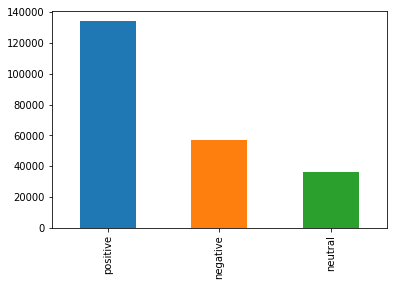

In [8]:
chinese_reviews_df_full['sentiment'].value_counts().plot(kind='bar')

The histogram above shows that there are more positve reviews.

## Analysis of Data Imbalance

Based on the above, the split among the sentiment labels is about 50:26:24 percent (positive:negative:neutral). We will see if we need to downsample the reviews with neutral sentiment after we get the preliminary model results. 

## Top 20 Positive Reviews Restaurants

In [9]:
top_reviewed = chinese_reviews_df_full[chinese_reviews_df_full["sentiment"]=='positive']
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)
print(topbusiness.head())

              business_id  rated
0  OX0T9dWI8b7meu-ljTo22A     72
1  SVMR0kRmdd-bbSNTTECJBA    125
2  szhJLmdLDVFTevm8fu0T4A    269
3  A2pHOVp0zh7grb1bbZxoBQ     53
4  JPfi__QJAaRzmfh5aOyFEw    759


              business_id  rated         Business name  \
0  OX0T9dWI8b7meu-ljTo22A     72           Long Wong's   
1  SVMR0kRmdd-bbSNTTECJBA    125          Super Dragon   
2  szhJLmdLDVFTevm8fu0T4A    269    Great Wall Cuisine   
3  A2pHOVp0zh7grb1bbZxoBQ     53         Little Peking   
4  JPfi__QJAaRzmfh5aOyFEw    759  Shang Artisan Noodle   

                                          categories  
0  American (Traditional), Pizza, Restaurants, Ar...  
1                Seafood, Chinese, Restaurants, Soup  
2           Chinese, Dim Sum, Restaurants, Cantonese  
3                               Chinese, Restaurants  
4  Asian Fusion, Restaurants, Chinese, Soup, Noodles  


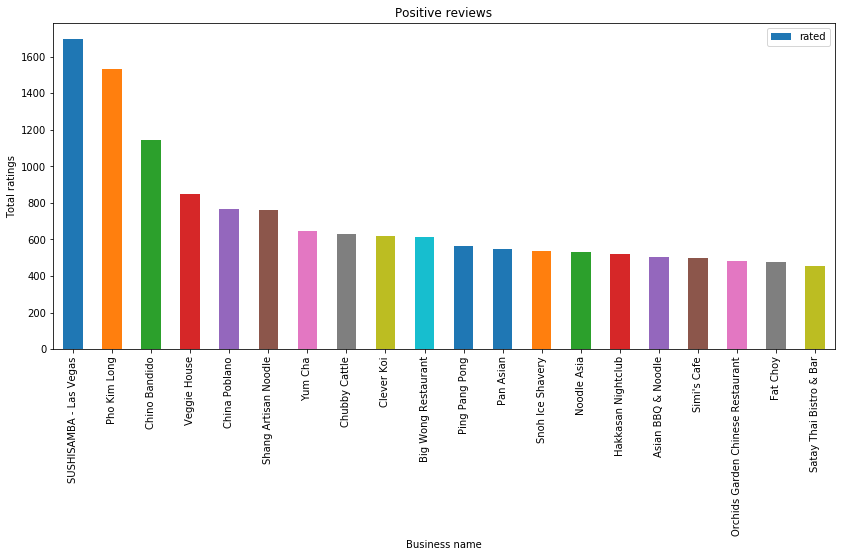

In [10]:
top_count= 20
right=pd.DataFrame(chinese_restaurants[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')

print(top_business_data.head())
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)


## Top 20 Negative Reviews Restaurants

In [11]:
bottom_reviewed = chinese_reviews_df_full[chinese_reviews_df_full["sentiment"]=='negative']
bottom_reviews_dict ={}

for business_id in bottom_reviewed["business_id"].values:
    try :
        bottom_reviews_dict[business_id] =bottom_reviews_dict[business_id]+1
    except:
        bottom_reviews_dict[business_id]=1
        
bottombusiness = pd.DataFrame.from_dict(data= bottom_reviews_dict,orient="index")

bottombusiness.reset_index(inplace=True)
bottombusiness.columns = ['business_id', 'rated']
del(bottom_reviews_dict)
del(bottom_reviewed)
print(bottombusiness.head())

              business_id  rated
0  OX0T9dWI8b7meu-ljTo22A     31
1  SVMR0kRmdd-bbSNTTECJBA     29
2  szhJLmdLDVFTevm8fu0T4A     84
3  A2pHOVp0zh7grb1bbZxoBQ      9
4  JPfi__QJAaRzmfh5aOyFEw     38


              business_id  rated         Business name  \
0  OX0T9dWI8b7meu-ljTo22A     31           Long Wong's   
1  SVMR0kRmdd-bbSNTTECJBA     29          Super Dragon   
2  szhJLmdLDVFTevm8fu0T4A     84    Great Wall Cuisine   
3  A2pHOVp0zh7grb1bbZxoBQ      9         Little Peking   
4  JPfi__QJAaRzmfh5aOyFEw     38  Shang Artisan Noodle   

                                          categories  
0  American (Traditional), Pizza, Restaurants, Ar...  
1                Seafood, Chinese, Restaurants, Soup  
2           Chinese, Dim Sum, Restaurants, Cantonese  
3                               Chinese, Restaurants  
4  Asian Fusion, Restaurants, Chinese, Soup, Noodles  


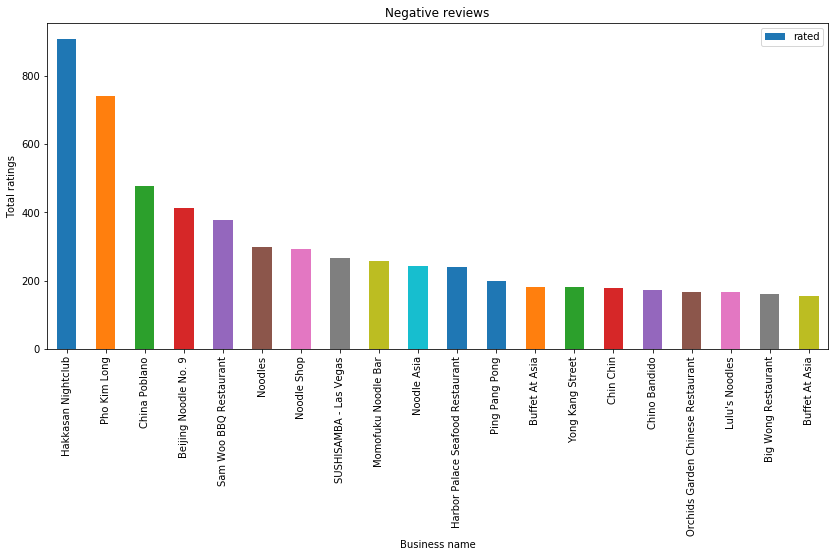

In [12]:
top_count= 20
right=pd.DataFrame(chinese_restaurants[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

bottom_business_data = pd.merge(bottombusiness,right=right, how="inner",on='business_id')

print(bottom_business_data.head())
bottom_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews').set_ylabel("Total ratings")

del(bottombusiness)
del(right)

## Where These Restaurants Are

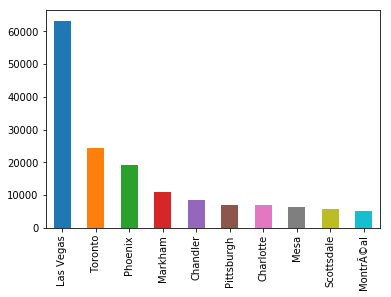

In [13]:
chinese_reviews_df_full['city'].value_counts().head(10).plot(kind='bar')

As we can see above, most reviewed restaurants come from Las Vegas. This makes sense as the city is a top tourist destination. Toronto comes in second.

In [16]:
# these are helper functions 
# directly copied from https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52

def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words


def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

# Word Cloud Analysis for the Top Positive and Negative Restaurants

## Word Cloud for Top 3 Most Negative Restaurants

We would like to see the most frequent words used by the reviewers for the top 3 most negative restaurants: Hakkasan Night Club, Pho King Long, China Poblano. For each restaurant, we select the review texts where the sentiment is negative. Here we produce the most common 2-word and 3-word phrase and a word cloud to summarize the most frequent word and phrases

Analysing business:  Hakkasan Nightclub
----- 10 most common 2-word phrase -----
dance floor: 342
guest list: 162
bottle service: 125
calvin harris: 105
hip hop: 92
many people: 72
las vegas: 63
told us: 57
see tiesto: 52
go back: 52

----- 10 most common 3-word phrase -----
hip hop room: 46
guest list line: 24
see calvin harris: 22
main dance floor: 19
dance floor small: 18
go somewhere else: 17
worst club ever: 16
table bottle service: 15
never come back: 14
packed like sardines: 14



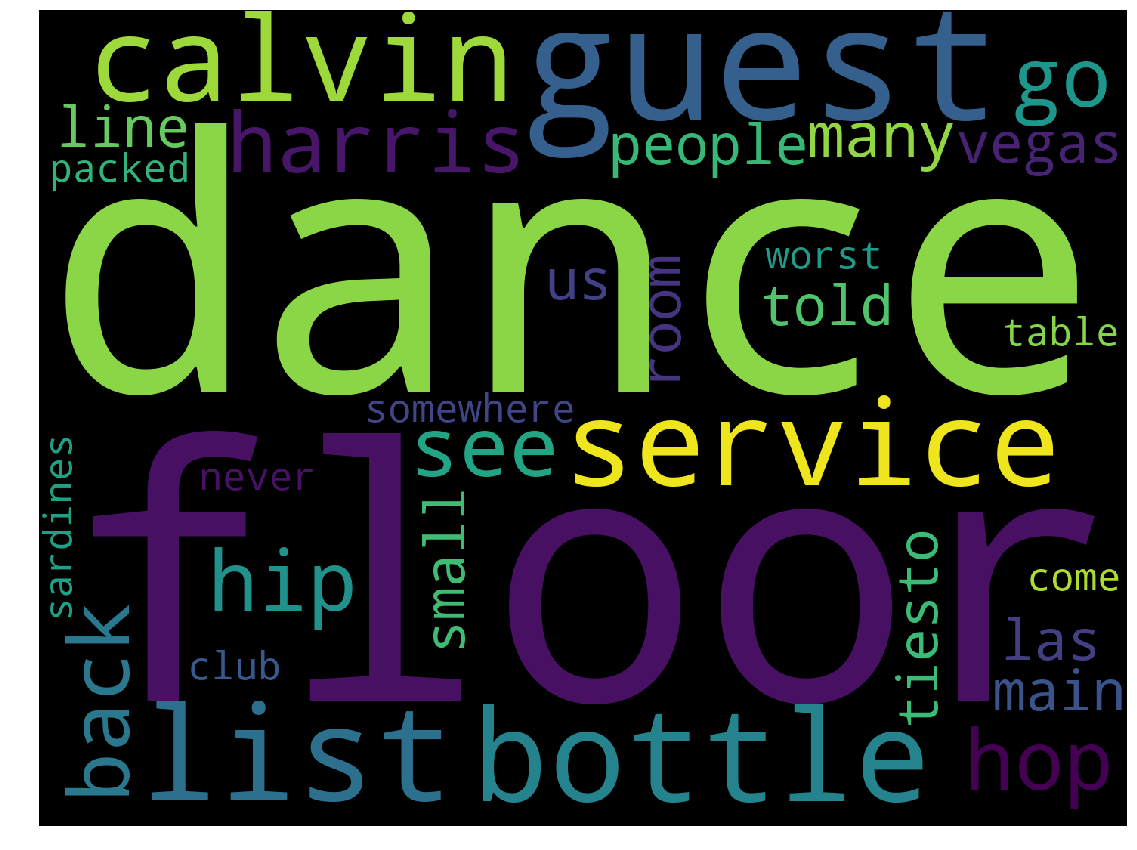


Analysing business:  Pho Kim Long
----- 10 most common 2-word phrase -----
customer service: 117
pho kim: 96
kim long: 93
spring rolls: 73
come back: 62
fried rice: 46
open 24: 45
first time: 40
24 hours: 39
bad service: 38

----- 10 most common 3-word phrase -----
pho kim long: 87
bun bo hue: 31
open 24 hours: 28
never come back: 17
worst service ever: 15
open 24 7: 13
never go back: 11
never coming back: 10
place open 24: 9
go somewhere else: 8



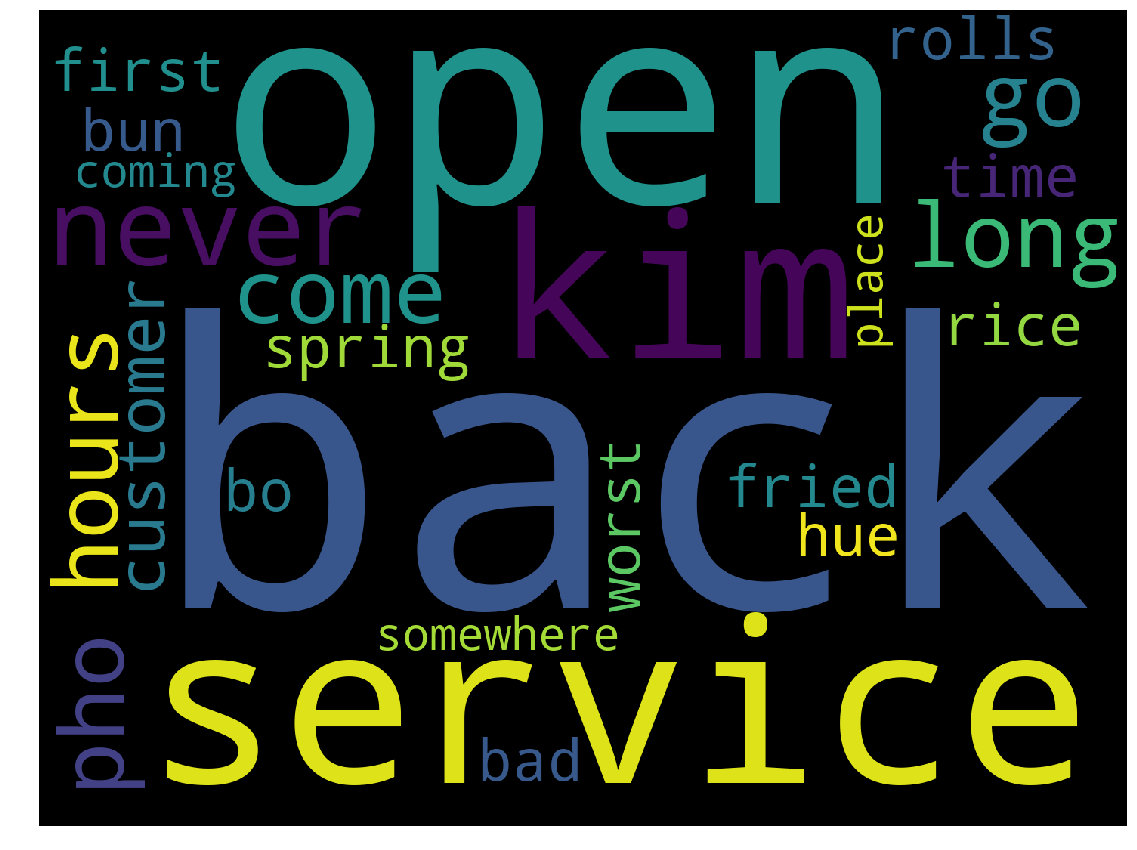


Analysing business:  China Poblano
----- 10 most common 2-word phrase -----
china poblano: 91
chinese mexican: 83
fried rice: 78
mexican food: 71
chinese food: 65
dim sum: 54
chips salsa: 51
jose andres: 50
dan dan: 41
tasted like: 39

----- 10 most common 3-word phrase -----
chinese mexican food: 33
vegetable fried rice: 27
dan dan mian: 24
hot sour soup: 17
20 vegetable fried: 11
dan dan noodles: 11
mexican chinese food: 11
rou jia mo: 11
salt air margarita: 9
twenty vegetable fried: 9



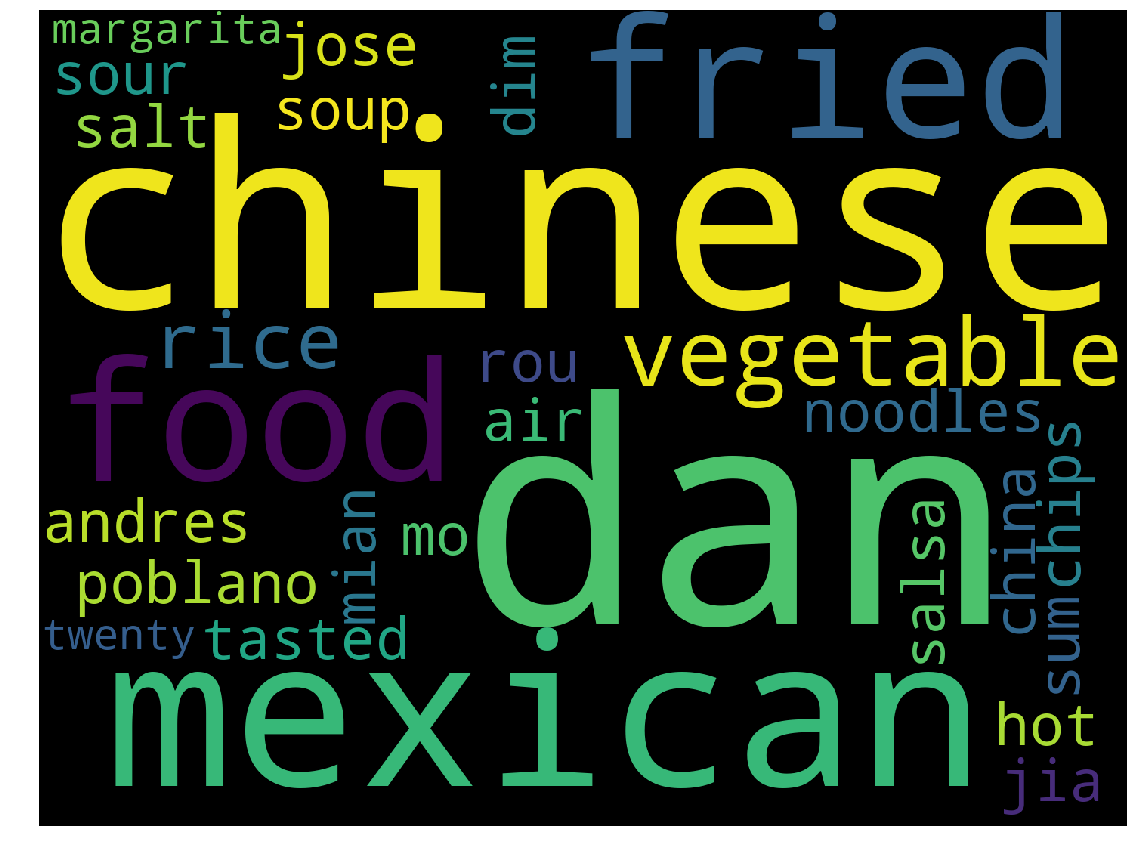

In [15]:
num_business_analysis = 3 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = chinese_reviews_df_full.loc[(chinese_reviews_df_full['business_id'] == business_id) & (chinese_reviews_df_full['sentiment'] == 'negative')].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)

## Word Cloud for Top 3 Most Positive Restaurants

We would like to see the most frequent words used by the reviewers for the top 3 most postive restaurants: Pho King Long, SUSHISAMBA - Las Vegas and China Poblano. For each restaurant, we select the review texts where the sentiment is negative. Here we produce the most common 2-word and 3-word phrase and a word cloud to summarize the most frequent word and phrases

Analysing business:  SUSHISAMBA - Las Vegas
----- 10 most common 2-word phrase -----
sea bass: 435
sushi samba: 372
peruvian corn: 155
las vegas: 136
happy hour: 126
highly recommend: 117
sushi rolls: 113
wagyu beef: 113
come back: 112
really good: 106

----- 10 most common 3-word phrase -----
sea bass skewers: 77
chilean sea bass: 75
rock shrimp tempura: 46
salt pepper squid: 41
wagyu beef gyoza: 39
japanese brazilian peruvian: 39
el topo roll: 36
green bean tempura: 35
japanese peruvian brazilian: 32
definitely come back: 31



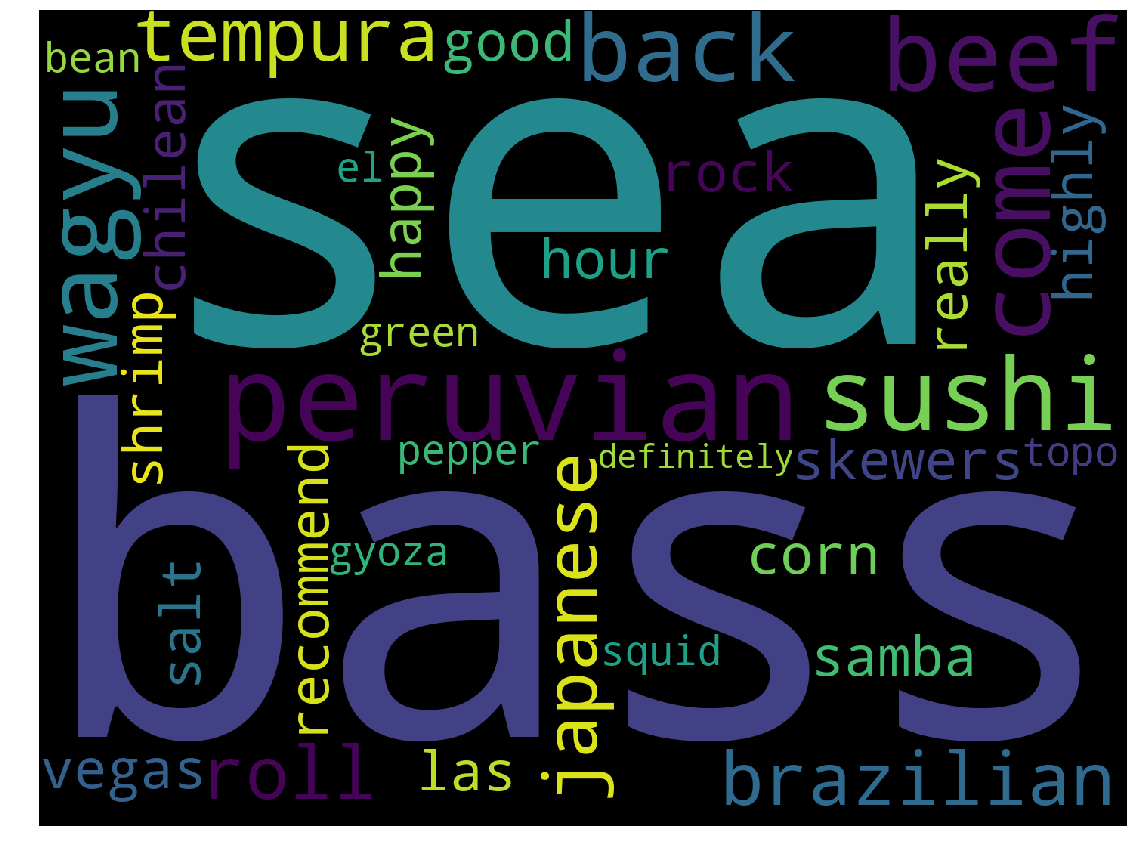


Analysing business:  Pho Kim Long
----- 10 most common 2-word phrase -----
kim long: 326
pho kim: 319
open 24: 234
24 hours: 191
spring rolls: 182
egg rolls: 164
late night: 134
las vegas: 132
best pho: 124
pho place: 113

----- 10 most common 3-word phrase -----
pho kim long: 303
open 24 hours: 144
open 24 7: 68
place open 24: 40
bun bo hue: 35
pho dac biet: 30
open 24 hrs: 22
fried egg rolls: 22
best pho ever: 21
rare steak brisket: 21



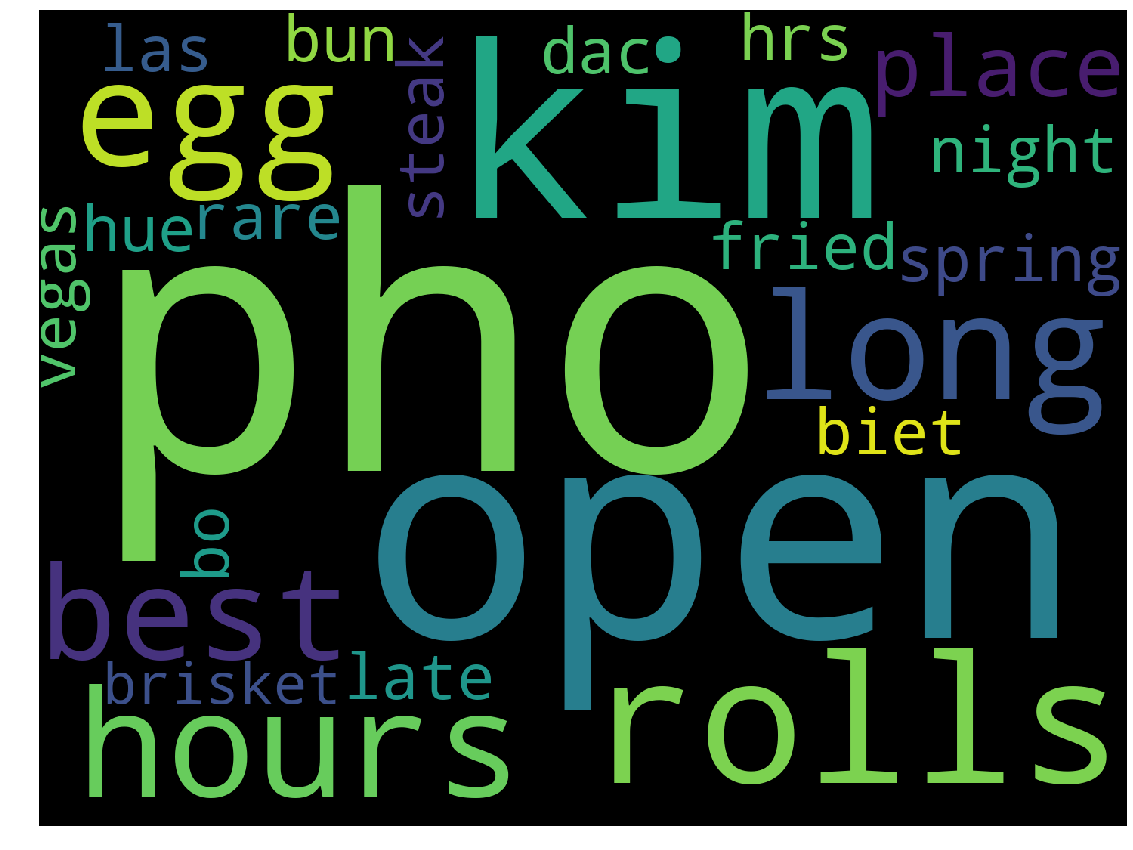


Analysing business:  Chino Bandido
----- 10 most common 2-word phrase -----
fried rice: 441
jade red: 384
red chicken: 378
black beans: 319
jerk chicken: 250
jerk fried: 234
jade chicken: 198
chino bandido: 190
emerald chicken: 179
first time: 154

----- 10 most common 3-word phrase -----
jade red chicken: 354
jerk fried rice: 227
pork fried rice: 79
chicken fried rice: 73
rice black beans: 68
chicken jerk fried: 52
red jade chicken: 51
fried rice black: 48
black beans jerk: 45
beans jerk fried: 44



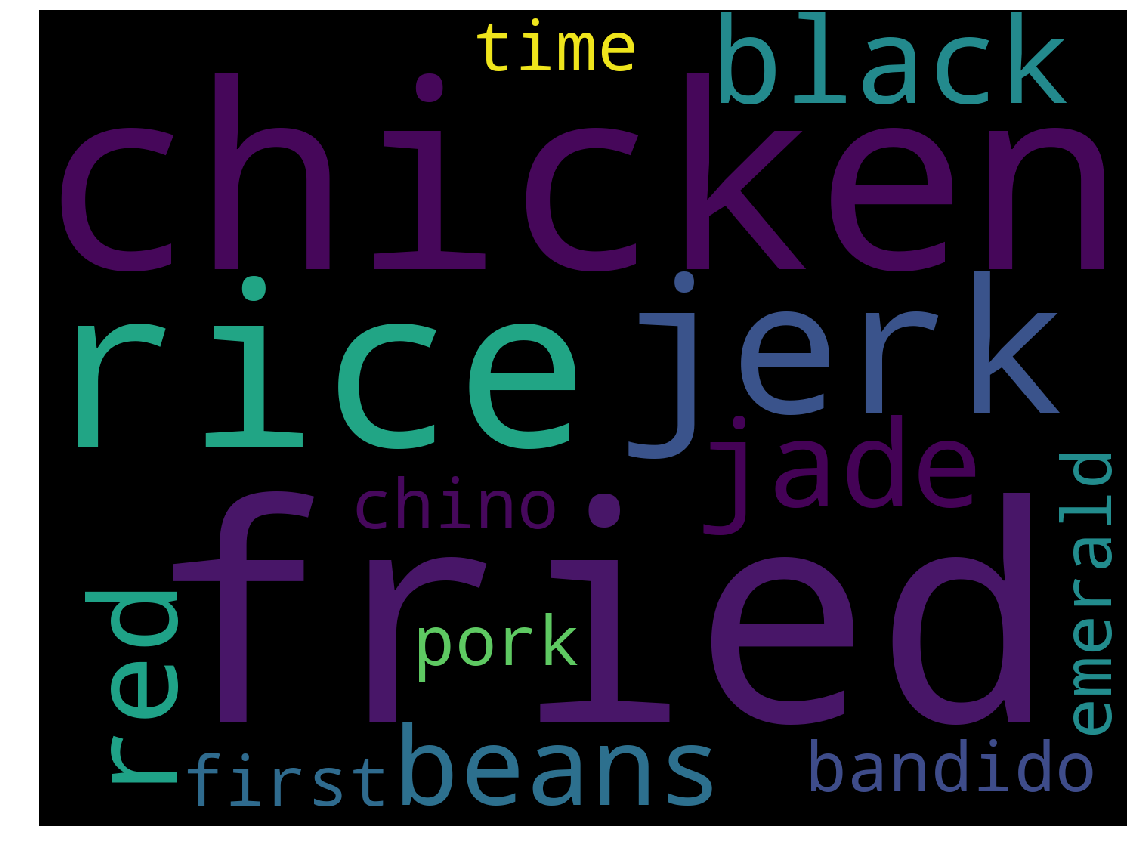

In [22]:
num_business_analysis = 3 # basically this will tell how much computing and diverse our analysis will be
business_ids=top_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = top_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = chinese_reviews_df_full.loc[(chinese_reviews_df_full['business_id'] == business_id) & (chinese_reviews_df_full['sentiment'] == 'positive')].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)

## Observations

* Not surprisingly, most of the most frequent words or phrases are food. However, based on the sentiment, we can tell what customers like or dislike.
* Pho Kim Long, located Las Vegas, appears in one of the most positive and negative reviews lists. The high volume of reviews can be attributed to the fact that the restaurant is open 24 hours a day, 7 days a week. This restaurant is frequented by tourists as we looked up their Yelp site: https://www.yelp.ca/biz/pho-kim-long-las-vegas

# Data Processing and Cleaning

This is a critical step to ensure that the texts are standardized and cleaned before the feature engineering/extraction. 

## Import Packages

In [17]:
import pandas as pd  
import numpy as np
import model_evaluation_utils as meu
import re
import nltk
from langdetect import detect_langs  
import langid
import re

## Data Preprocessing

### Language Detection

We would like to implement a language detection routine to eliminate any reviews that are not in English. As this is a very compututionally intensive routine, we did it separately from this notebook. We found that 99.5% of the reviews are in English. Nonetheless, we will remove the non-English reviews. Below are the statistics of the language detection algorithm:

en    226138
fr       614
de        65
es        29
no        13
af        13
ca        10
cy        10
it         9
sk         9
da         9
pt         8
nl         8
hr         6
sv         6
tl         6
ro         5
et         4
pl         4
vi         4
so         3
lv         3
sl         2
sq         2
tr         2
id         2
fi         1
sw         1
hu         1
cs         1
uk         1

In [3]:
#df = pd.read_csv('chinese_reviews_df_full.csv')
#def try_detect(cell):
#     try:
#        detected_lang = detect_langs(cell)
#     except:
#        detected_lang = None
#     return detected_lang

#df['language'] = df.text.apply(try_detect)
#df.to_csv('chinese_reviews_df_full_with_lang.csv')

### Import Dataset After Language Detection and Filter out non-English posts

In [4]:
df = pd.read_csv('chinese_reviews_df_norm_with_lang.csv')

## Treatment of Neutral Rating (3 Stars)

We have about 36K reviews that are rated as 3 stars. The neutral rating could cause issues for the sentiment predictions because the algorithms might not be able to determine whether certain reviews are neither positive nor negative. From the business' perspective, when a user decided to write a review, he/she should mostly express his/her positive or negative sentiment only. 

Therefore, we decided to treat the 3-star reviews by assiging them to negative so that the sentiment label will be binary.

In [19]:
#def randposorneg():
#    x = np.random.randint(2)
#    if x == 1:
#        return 'positive'
#    else:
#        return 'negative'
   
df = chinese_reviews_df_full
df['sentiment'] = np.where(df.stars > 3, 'positive', 
                        np.where(df.stars < 3, 'negative', 'negative'))

#neutral = df.index[df['stars']==3].tolist()

#for index in neutral:
#    df.loc['sentiment', index] = randposorneg()

print(df.head(20))

    funny                 user_id               review_id  \
0       0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1       0  ZuCXUnvBXN9wj2S8ZD40qw  0Z4uMWbCUKKtzDFeOoQt3Q   
2       0  NH7hMsA2Mogeboht1-XEVQ  AKTWTO0aUe8GMnax51aSjA   
3       0  o5hp_ni5e0SrCTczzEajuA  qrNDl6NDPS_4u8T5VJMx9g   
4       0  4SJbA5cVsHHVBt3bpGHTzg  HFFV71RDN0odsR1a7Bc9oA   
5       0  NgDCsViaIU1W4_btvNl6RA  hPBXIWx9v9U3Rl0r02qRHw   
6       0  1l7ELHpI7tal9iXHlNZ0Lw  QS8TXYCsxXXTqhjEOyl3JQ   
7       0  4geCNjITk3agQLY95VpGMg  mZS-0w-9Oih8-NpQAS1new   
8       0  vcyweCcWRsWNdaAgszY3Pg  U2MJGHYxwVGuXX8t-ifQfg   
9       0  xip7XHJoRILgvJciGyKoJw  OUtaMEQRPHjxXzmXZXq_Qg   
10      0  UZ_nVx6KoevEy9NVpRiRtg  949U2ibQk8cAcVTLNY7Izw   
11      0  4SM_JIV-ZUk5ZI87dTKEtQ  GkZO3eW141EsutfO-W-grw   
12      1  1kLSiPP6hX-jRVDjfYXtkQ  dYq7FPNzNhJlpLHNDHFM7w   
13      0  oqjgYAF9fq_-U8EEAom9UQ  eg1j2zaiZWZSbWqSnyQHSA   
14      0  _i5K77RsSeBfn3HFCcKj0Q  TcyXJkRYfrFyLlsXAWPGzg   
15      0  TcrnuDDjpO6jj

In [20]:
len(df.index)

227132

In [21]:
df.language.value_counts()

AttributeError: 'DataFrame' object has no attribute 'language'

In [8]:
df = df[df['language'] == "en"]

In [22]:
len(df.index)

227132

In [23]:
df.language.value_counts()

AttributeError: 'DataFrame' object has no attribute 'language'

### Texts Cleaning

Here are the steps that we are going to deploy:

* Convert all the uppercase characters to lowercase
* Remove punctuations
* Remove numbers
* Remove stopwords
* Lemmatization

In [24]:
df ['word_count'] = df ['text'].apply(lambda x: len(str(x).split(" ")))
print(df [['text','word_count']].head())

# Turn into lower case   
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(df['text'].head())

# Remove Punctuation 
df['text'] = df['text'].str.replace('[^\w\s]','')
print(df['text'].head())

# Remove Numbers
df['text'] = df['text'].str.replace('[0-9]', '')
print(df['text'].head())

# Remove Stop Words    
from nltk.corpus import stopwords  

stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))
print(df['text'].head())

# Lemmatization (instead of Stemming)

from textblob import Word

df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(df['text'].head())

# Count the number of rows where the text field is empty
empty_text = len(df[df['text']==''])
print(empty_text)

# Remove the rows that have empty text as a result of the data cleaning routines

df = df[df['text']!='']

                                                text  word_count
0  Friendliest staff, no matter how swamped they ...          35
1  getting some food I wish it was a lot bigger t...          30
2  The place is a pit and it always has been a pi...          61
3  I have been coming to long wongs for 10 years!...          21
4  For the most part it's a unique and different ...          42
0    friendliest staff, no matter how swamped they ...
1    getting some food i wish it was a lot bigger t...
2    the place is a pit and it always has been a pi...
3    i have been coming to long wongs for 10 years!...
4    for the most part it's a unique and different ...
Name: text, dtype: object
0    friendliest staff no matter how swamped they a...
1    getting some food i wish it was a lot bigger t...
2    the place is a pit and it always has been a pi...
3    i have been coming to long wongs for 10 years ...
4    for the most part its a unique and different p...
Name: text, dtype: object
0    fri

In [60]:
#print(train_sentiments.head())
#print(train_sentiments.shape)
#df1 = df1.drop(columns=['neighborhood'])
#print(df1.head())

train_reviews.to_csv('chinese_reviews_cleaned_text_sentiment_10000.csv', index=False)
#train_i = round(0.7*df_length)

#train_reviews = df1[:100000]


#train_reviews = train_reviews.drop(columns=[' '])
#print(train_reviews.head())
#print(train_reviews.shape)
#df = train_reviews
#write.csv(train_reviews, "train_reviews.csv", row.names=FALSE)



In [25]:
df.to_csv('chinese_reviews_cleaned.csv')

## Ling Changed here: removing star == 3

Target treatment: Because when star==3, it is not sure whether the sentiment is positive or negative, so we remove stars == 3 first, so as to get a more accurate model that can predict positive and negative.

In [8]:
# read in data
df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
df = df[df['stars'] != 3]

# Feature Engineering and Model Implementation

Feature engineering and extraction are particularly important to Sentiment Analysis. The idea is to transform the texts by creating useful features with the goal to increase the prediction accuracy. In NLP, there are a few effective features that we can use:

* Bag-of-Words (BOW) - The BOW feature extraction model simply counts the word frequency and occurrence from the corpus without concerning about the grammar, word orders and sequences. 
* N-grams - N-grams is the extension of the BOW model which takes in a collection of word tokens from the document. N denotes the number of words in a collection (e.g. uni-gram is 1 word which is BOW, bi-gram is 2 words, tri-gram is 3 words and so on)
* Term Frequency–Inverse Document Frequency (TF-IDF) - It a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. 

The models that we are going to implement are Logistic Regression and Support Vector Machine (SVM). We will implement each of these features and then feed into each of the two models, and then compare the prediction results


## Split the Dataset into Train and Test Datasets

For simplicity with regards to the mid-term proposal, we will split the dataset into train and test datasets using the 70-30 split. Later on, we will consider and implement the cross validation algorithms, and then compare the prediction results. 

In [13]:
# build train and test datasets

#df_length = len(df['text'])
#print(df_length)

#train_i = round(0.7*df_length)

#train_reviews = df['text'][:train_i]
#train_sentiments = df['sentiment'][:train_i]
#test_reviews = df['text'][train_i:]
#test_sentiments = df['sentiment'][train_i:]


In [27]:
#df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
#df = df[df['stars'] != 3]
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(df['text'], df['sentiment'],
                                                   test_size=0.3,
                                                   random_state=1,
                                                   stratify=df['sentiment'])

## <font color='red'>Bag of Words (BOW)</font> 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# build BOW features on train reviews
cv = CountVectorizer(min_df=0., max_df=1.)
cv_train_features = cv.fit_transform(train_reviews)

# transform test reviews into features
cv_test_features = cv.transform(test_reviews)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (133134, 88639)  Test features shape: (57058, 88639)


### <font color='blue'>Model - Logistic Regression for BOW</font> 

Now we will use the logistic regression model to predict the sentiment.

In [12]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
import model_evaluation_utils as meu

lr = LogisticRegression(penalty='l2', max_iter=500, C=1)

# Logistic Regression model on BOW features
lr_bow_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                      classes=['positive', 'negative'])

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.944
Precision: 0.9437
Recall: 0.944
F1 Score: 0.9437

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.95      0.97      0.96     40058
    negative       0.92      0.89      0.90     17000

   micro avg       0.94      0.94      0.94     57058
   macro avg       0.94      0.93      0.93     57058
weighted avg       0.94      0.94      0.94     57058


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      38736     1322
        negative       1873    15127


### <font color='blue'>Model - Support Vector Machine (SVM) for BOW</font>  

In [13]:
svm = SGDClassifier(loss='hinge', n_iter=500)
svm_bow_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                      classes=['positive', 'negative'])

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.9465
Precision: 0.9462
Recall: 0.9465
F1 Score: 0.9462

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.96      0.97      0.96     40058
    negative       0.93      0.89      0.91     17000

   micro avg       0.95      0.95      0.95     57058
   macro avg       0.94      0.93      0.94     57058
weighted avg       0.95      0.95      0.95     57058


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      38828     1230
        negative       1823    15177


## <font color='red'>TF-IDF</font> 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)
tv_test_features = tv.transform(test_reviews)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (133134, 2036213)  Test features shape: (57058, 2036213)


### <font color='blue'>Model - Logistic Regression for TF-IDF</font> 

In [15]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=train_sentiments,
                                               test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9491
Precision: 0.949
Recall: 0.9491
F1 Score: 0.9486

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.95      0.98      0.96     40058
    negative       0.95      0.88      0.91     17000

   micro avg       0.95      0.95      0.95     57058
   macro avg       0.95      0.93      0.94     57058
weighted avg       0.95      0.95      0.95     57058


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      39204      854
        negative       2050    14950


### <font color='blue'>Model - Support Vector Machine (SVM) for TF-IDF</font> 

In [16]:
svm = SGDClassifier(loss='hinge', n_iter=500)
svm_tdidf_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=tv_train_features, train_labels=train_sentiments,
                                             test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tdidf_predictions,
                                      classes=['positive','negative'])

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.9407
Precision: 0.9413
Recall: 0.9407
F1 Score: 0.9396

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.94      0.98      0.96     40058
    negative       0.95      0.84      0.89     17000

   micro avg       0.94      0.94      0.94     57058
   macro avg       0.94      0.91      0.93     57058
weighted avg       0.94      0.94      0.94     57058


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      39362      696
        negative       2688    14312


## <font color='red'>Bag of N-Grams</font> 

In [17]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(1,2))
bv_train_features = bv.fit_transform(train_reviews)

# transform test reviews into features
bv_test_features = bv.transform(test_reviews)

print('Bag of N-Grams model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

Bag of N-Grams model:> Train features shape: (133134, 88639)  Test features shape: (57058, 88639)


### <font color='blue'>Model - Logistic Regression for Bag of N-Grams</font> 

In [18]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)

# Logistic Regression model on BOW features
lr_bagofgrams_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=bv_train_features, train_labels=train_sentiments,
                                             test_features=bv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bagofgrams_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9554
Precision: 0.9552
Recall: 0.9554
F1 Score: 0.9552

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.96      0.97      0.97     40058
    negative       0.94      0.91      0.92     17000

   micro avg       0.96      0.96      0.96     57058
   macro avg       0.95      0.94      0.95     57058
weighted avg       0.96      0.96      0.96     57058


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      39054     1004
        negative       1541    15459


### <font color='blue'>Model - Support Vector Machine (SVM) for Bag of N-Grams</font> 

In [19]:
svm = SGDClassifier(loss='hinge', n_iter=500)
svm_bagofgrams_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=bv_train_features, train_labels=train_sentiments,
                                             test_features=bv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bagofgrams_predictions,
                                      classes=['positive', 'negative'])

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.9532
Precision: 0.953
Recall: 0.9532
F1 Score: 0.953

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.96      0.97      0.97     40058
    negative       0.93      0.91      0.92     17000

   micro avg       0.95      0.95      0.95     57058
   macro avg       0.95      0.94      0.94     57058
weighted avg       0.95      0.95      0.95     57058


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      38961     1097
        negative       1574    15426


## Prediction Results Analysis

As we can see, the prediction results shown above using the Logistic Regression and SVM models and 3 types of Feature Engineering: BOW, TF-IDF and Bags-of-N-Grams are around 88%. After we eliminated the neutral rating, the model performance was significantly increased. 

Below we are implementing the cross validation routines.

## Cross Validation

We will use cross validation on the TF-IDF + Logistic Regression model, which gave the best prediction results measured by Precision among all models that we have implemented.

In [20]:
#CROSS VALIDATION

from sklearn.feature_extraction.text import TfidfVectorizer
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_features = tv.fit_transform(df['text'])
print(tv_features.shape)

(190192, 2603274)


In [21]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
import model_evaluation_utils as meu

lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
#scores = cross_val_score(lr, tv_features, df['sentiment'], cv=5)

from sklearn.model_selection import cross_val_predict
lr_tfidf_predictions = cross_val_predict(lr, tv_features, df['sentiment'], cv=5)
meu.display_model_performance_metrics(true_labels=df['sentiment'], predicted_labels=lr_tfidf_predictions,
                                      classes=['positive', 'negative'])

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.9496
Precision: 0.9495
Recall: 0.9496
F1 Score: 0.949

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.95      0.98      0.96    133526
    negative       0.95      0.88      0.91     56666

   micro avg       0.95      0.95      0.95    190192
   macro avg       0.95      0.93      0.94    190192
weighted avg       0.95      0.95      0.95    190192


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive     130699     2827
        negative       6762    49904


## K-Fold Cross Validation

In [23]:
# K-FOLD

from sklearn.model_selection import KFold 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import model_evaluation_utils as meu

kf = KFold(n_splits=5,shuffle=True,random_state=2652124)
 
for train_index, test_index in kf.split(df['text']):
    print("Train:", train_index, "Validation:",test_index)      
    df_review_train, df_review_test = df['text'][train_index], df['text'][test_index]      
    df_sentiment_train, df_sentiment_test = df['sentiment'][train_index], df['sentiment'][test_index]
    # build TFIDF features on train reviews
    tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
    tv_train_features = tv.fit_transform(df_review_train)
    tv_test_features = tv.transform(df_review_test)
    print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)
    # Logistic Regression model on TF-IDF features
    lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
    lr.fit(tv_train_features, df_sentiment_train)
    # predict using model
    predictions = lr.predict(tv_test_features) 
    meu.get_metrics(df_sentiment_test, predictions)
    meu.display_confusion_matrix(df_sentiment_test, predictions, classes=['positive', 'negative'])


Train: [     0      3      4 ... 190189 190190 190191] Validation: [     1      2      8 ... 190178 190180 190187]


ValueError: np.nan is an invalid document, expected byte or unicode string.

### Cross Validation - Model Evaluation Analysis

We observed that the prediction results for each fold are similar. The precision and recall metrics are around 88% - 89%

# Ensemble Models

In [2]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict

## Bagging - Reduce Variance

In [7]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
svm = SGDClassifier(loss='hinge', n_iter=500) 

In [8]:
bagging1 = BaggingClassifier(base_estimator=lr, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=svm, n_estimators=10, max_samples=0.8, max_features=0.8)

In [7]:
df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
df = df[df['stars'] != 3]
from sklearn.feature_extraction.text import TfidfVectorizer
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_features = tv.fit_transform(df['text'])
print(tv_features.shape)

(190192, 2603274)


In [8]:
label = ['Logistic Regression', 'SVM', 'Bagging LR', 'Bagging SVM']
clf_list = [lr, svm, bagging1, bagging2]

#fig = plt.figure(figsize=(10, 8))
#gs = gridspec.GridSpec(2, 2)
#grid = itertools.product([0,1],repeat=2)

for clf, label in zip(clf_list, label):       
    scores = cross_val_score(clf, tv_features, df['sentiment'], cv=5, scoring='accuracy')
    #print(scores)
    print("Accuracy: %.6f (+/- %.6f) [%s]" %(scores.mean(), scores.std(), label))
    
    #clf.fit(tv_features, df['sentiment'])
    #ax = plt.subplot(gs[grd[0], grd[1]])
    #fig = plot_decision_regions(X=tv_features, y=df['sentiment'], clf=clf, legend=2)
    #plt.title(label)

#plt.show()

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.949583 (+/- 0.000899) [Logistic Regression]


/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.

Accuracy: 0.937064 (+/- 0.001371) [SVM]


/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

Accuracy: 0.944072 (+/- 0.001152) [Bagging LR]


/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.

Accuracy: 0.925212 (+/- 0.001333) [Bagging SVM]


## Ling added this: Bag of N-Gram as feature engineering

Based on the results of our previous attempts of feature engineering X single model, Bag of N-Gram produces the best results among 3 feature engineering methods, so we tried Bag of N-Gram.

Note in below results, using Bag of N-Gram on whole dataset produced as many features as TF-IDF, so the computational efforts is the same; however Bag of N-Gram does get better results than TF-IDF.

In [2]:
# build Bag of N-Grams features
df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
df = df[df['stars'] != 3]
from sklearn.feature_extraction.text import CountVectorizer
bv = CountVectorizer(ngram_range=(1,2))
bv_features = bv.fit_transform(df['text'])
print(bv_features.shape)

(190192, 2603274)


In [ ]:
label = ['Logistic Regression', 'SVM', 'Bagging LR', 'Bagging SVM']
clf_list = [lr, svm, bagging1, bagging2]

for clf, label in zip(clf_list, label):       
    scores = cross_val_score(clf, bv_features, df['sentiment'], cv=5, scoring='accuracy')
    #print(scores)
    print("Accuracy: %.6f (+/- %.6f) [%s]" %(scores.mean(), scores.std(), label))

/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.955256 (+/- 0.000903) [Logistic Regression]


/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/zhllcanada/.local/lib/python3.

Accuracy: 0.954041 (+/- 0.001243) [SVM]


/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/zhllcanada/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
y = np.where(df['sentiment'] == 'positive', 1, 0)
X_train, X_test, y_train, y_test = train_test_split(bv_features, y, test_size=0.3, random_state=42)
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

## Random Forest

### Decision Tree Model

## Ling's note: I did not change the below cell from the "golden" nootbook, I made a new cell bellow.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict
import model_evaluation_utils as meu

#df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
#df = df[df['stars'] != 3]

dt = DecisionTreeClassifier(criterion='entropy', max_depth=1)
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_features = tv.fit_transform(df['text'])
print(tv_features.shape)

predictions = cross_val_predict(dt, tv_features, df['sentiment'], cv=5)

meu.display_model_performance_metrics(true_labels= df['sentiment'], predicted_labels = predictions,
                                      classes=['positive', 'negative'])



(226138, 3005206)
Model Performance metrics:
------------------------------
Accuracy: 0.5905


C:\Users\benny\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.3486
Recall: 0.5905


C:\Users\benny\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.4384

Model Classification report:
------------------------------


C:\Users\benny\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    positive       0.59      1.00      0.74    133526
    negative       0.00      0.00      0.00     92612

   micro avg       0.59      0.59      0.59    226138
   macro avg       0.30      0.50      0.37    226138
weighted avg       0.35      0.59      0.44    226138


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive     133526        0
        negative      92612        0


## Ling Changed this: For Decision Tree, I made this new cell, where I used bv

#### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict
import model_evaluation_utils as meu

#df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
#df = df[df['stars'] != 3]

dt = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
#                      sublinear_tf=True)
# tv_features = tv.fit_transform(df['text'])
# print(tv_features.shape)

#y = np.where(df['sentiment'] == 'positive', 1, 0)

predictions = cross_val_predict(dt, cv_features, y, cv=5)

meu.display_model_performance_metrics(true_labels= y, predicted_labels = predictions,
                                      classes=[1, 0])

### Random Forest

In [4]:
clf_rf = RandomForestClassifier(n_estimators=10)
predictions = cross_val_predict(clf_rf, tv_features, df['sentiment'], cv=5)
meu.display_model_performance_metrics(true_labels= df['sentiment'], predicted_labels = predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.8022
Precision: 0.8014
Recall: 0.8022
F1 Score: 0.8016

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.83      0.84      0.83    133526
    negative       0.77      0.74      0.75     92612

   micro avg       0.80      0.80      0.80    226138
   macro avg       0.80      0.79      0.79    226138
weighted avg       0.80      0.80      0.80    226138


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive     112605    20921
        negative      23820    68792


## Boosting

We are implementing adaptive boosting to see if we can improve the prediction results. We are using TF-IDF for the feature engineering and logistic regression as the base classifier. The result is compared against the same FE/model combination without the boosting.

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
import model_evaluation_utils as meu

In [54]:
df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
df = df[df['stars'] != 3]
# df['sentiment'] = np.where(df.stars > 3, 'positive', 
#                         np.where(df.stars < 3, 'negative', 'negative'))


In [56]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(df['text'], df['sentiment'],
                                                   test_size=0.3,
                                                   random_state=1,
                                                   stratify=df['sentiment'])

from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)
tv_test_features = tv.transform(test_reviews)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

#lr = LogisticRegression()
#svm = DecisionTreeClassifier(criterion='entropy', max_depth=1)
svm = SGDClassifier(loss='hinge', n_iter=500)

svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=tv_train_features, train_labels=train_sentiments,
                                             test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                      classes=['positive', 'negative'])


TFIDF model:> Train features shape: (158296, 2357733)  Test features shape: (67842, 2357733)


C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.8765
Precision: 0.8778
Recall: 0.8765
F1 Score: 0.8751

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.87      0.93      0.90     40058
    negative       0.89      0.79      0.84     27784

   micro avg       0.88      0.88      0.88     67842
   macro avg       0.88      0.86      0.87     67842
weighted avg       0.88      0.88      0.88     67842


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      37454     2604
        negative       5775    22009


In [57]:
num_est = 100
ada_clf = AdaBoostClassifier(base_estimator=svm, n_estimators=num_est,algorithm='SAMME')   
ada_clf.fit(tv_train_features, train_sentiments)

# predict using model
predictions = ada_clf.predict(tv_test_features) 
#meu.get_metrics(test_sentiments, predictions)
#meu.display_confusion_matrix(test_sentiments, predictions, classes=['positive', 'neutral', 'negative'])

meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions,
                                      classes=['positive', 'negative'])

C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochast

Model Performance metrics:
------------------------------
Accuracy: 0.8536
Precision: 0.8564
Recall: 0.8536
F1 Score: 0.8543

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.90      0.85      0.87     40058
    negative       0.80      0.86      0.83     27784

   micro avg       0.85      0.85      0.85     67842
   macro avg       0.85      0.85      0.85     67842
weighted avg       0.86      0.85      0.85     67842


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      34110     5948
        negative       3982    23802


## Stacking

In [2]:
from sklearn.model_selection import train_test_split
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
df = df[df['stars'] != 3]
# df['sentiment'] = np.where(df.stars > 3, 1, 
#                         np.where(df.stars < 3, 0, 0))

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(df['text'], df['sentiment'],
                                                   test_size=0.3,
                                                   random_state=1,
                                                   stratify=df['sentiment'])

tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)
tv_test_features = tv.transform(test_reviews)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)


TFIDF model:> Train features shape: (158296, 2357733)  Test features shape: (67842, 2357733)


In [18]:
import model_evaluation_utils as meu
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

clf1 = SGDClassifier(loss='hinge', n_iter=500)
clf2 = RandomForestClassifier(n_estimators=10)
clf3 = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=1) 
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)

df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
df = df[df['stars'] != 3]
#df['sentiment'] = np.where(df.stars > 3, 1, np.where(df.stars < 3, 0, 0))

tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_features = tv.fit_transform(df['text'])
print(tv_features.shape)

sclf = StackingClassifier(classifiers=[clf1,lr], meta_classifier=clf2)
sclf_predictions = cross_val_predict(sclf, tv_features, df['sentiment'], cv=5)

#scores = cross_val_score(sclf, tv_features, df['sentiment'], cv=5, scoring='accuracy')
#print("Accuracy: %.6f (+/- %.6f)" %(scores.mean(), scores.std()))

#sclf.fit(tv_train_features, train_sentiments)
# predict using model
#sclf_predictions = sclf.predict(tv_test_features) 

meu.display_model_performance_metrics(true_labels=df['sentiment'], predicted_labels=sclf_predictions, classes=[1, 0])

(226138, 3005206)


C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\benny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter param

Model Performance metrics:
------------------------------
Accuracy: 0.887
Precision: 0.8868
Recall: 0.887
F1 Score: 0.8865

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.89      0.92      0.91    133526
           0       0.88      0.84      0.86     92612

   micro avg       0.89      0.89      0.89    226138
   macro avg       0.89      0.88      0.88    226138
weighted avg       0.89      0.89      0.89    226138


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   1      0
Actual: 1     123194  10332
        0      15229  77383


### Ling's test starts below
the first 2 cells prepare data and model

In [1]:
import numpy as np # linear algebra
import pandas as pd
import model_evaluation_utils as meu
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

#df = pd.read_csv('chinese_reviews_df_full_with_lang_english_cleaned.csv')
#df['sentiment'] = np.where(df.stars > 3, 1, np.where(df.stars < 3, 0, 0))

In [2]:
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_features = tv.fit_transform(df['text'])
print(tv_features.shape)

(226138, 3005206)


In [5]:
svm = SGDClassifier(loss='hinge', n_iter=500)
rf = RandomForestClassifier(n_estimators=10)

nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=1) 
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=1)

### Strategies of stacking:

#### First, we tried to find the best performed meta model, by comparing results of 4 models as meta model.

As meta model needs to be simple, we tried to use 4 simple models, namely Naive Bayes, KNN, LogisticRegression and Decision Tree as base models relatively, so as to compare which model would be best to serve as base model.

In this process, we also kept in mind that base models need to be diversify, so that our stacking could make the best use of different types of algorithms. Therefore, we put different types of algorithms, including tree-based -- Random Forest; Liner -- SVM, KNN and Naive Bayes as base models.

#### Try 1: Meta model: NB; Base models: SVM, RF and KNN

In [ ]:
sclf = StackingClassifier(classifiers=[svm,rf,knn], meta_classifier=nb)

sclf_predictions = cross_val_predict(sclf, tv_features, df['sentiment'], cv=5)

meu.display_model_performance_metrics(true_labels=df['sentiment'], predicted_labels=sclf_predictions, classes=[1, 0])

In [ ]:
#### Try 2: Meta model: KNN; Base models: SVM, RF and NB

In [ ]:
sclf = StackingClassifier(classifiers=[svm,rf,nb], meta_classifier=knn)

sclf_predictions = cross_val_predict(sclf, tv_features, df['sentiment'], cv=5)

meu.display_model_performance_metrics(true_labels=df['sentiment'], predicted_labels=sclf_predictions, classes=[1, 0])

In [ ]:
#### Try 3: Meta model: LR; Base models: SVM, RF, NB, KNN

In [ ]:
sclf = StackingClassifier(classifiers=[svm,rf,nb, knn], meta_classifier=lr)

sclf_predictions = cross_val_predict(sclf, tv_features, df['sentiment'], cv=5)

meu.display_model_performance_metrics(true_labels=df['sentiment'], predicted_labels=sclf_predictions, classes=[1, 0])

In [ ]:
#### Try 4: Meta model: DT; Base models: SVM, RF, NB, KNN

In [ ]:
sclf = StackingClassifier(classifiers=[svm, rf, nb, knn], meta_classifier=dt)

sclf_predictions = cross_val_predict(sclf, tv_features, df['sentiment'], cv=5)

meu.display_model_performance_metrics(true_labels=df['sentiment'], predicted_labels=sclf_predictions, classes=[1, 0])

In [ ]:
#### Second, After we found that ## performed best as meta model, we tried to adjusted the base models in order to find the best stacking combination.

# Conclusion 

We used an unstructured dataset which consists of about 227K of Yelp reviews on Chinese restaurants. We performed the data exploration, data cleansing and language detection. Then implemented 3 feature engineering routines (BOW, TF-IDF and Bags-of-N-Grams) with 2 models (Logistic Regression and SVM) as well as evaluation metrics. In all cases, the prediction accuracy metrics using these models are very similar at about 58%-62%.We found that the feature engineering and the model that give the best prediction results are TF-IDF with Logistic Regression. 

We followed up with the implementation of the cross validation routines to validate prediction accuracy. We found that the accuracy stands at 62%. However, we found that the prediction of the positive and negative sentiments are particularly poor (with the F1-score in the 30s) with the majority of them being predicted as neutral.  

We then attempted to downsample the dataset whose reviews are rated as neutral and then run a sample model (TF-IDF + Logisti Regression). We found that while the overall prediction accuracies have dropped, the prediction accuracies for both positive and negative sentiments have improved significantly.

# Next Steps

We recognize that the prediction models and we implemented need improvements to increase the prediction accuracies. Here are the items that we will consider in the second phase of the project:

* Widen the scope of the dataset - Instead of being restricted to Yelp reviews for Chinese restaurants, we can widen our problem statement to collect more diversified user reviews. For example, we can explore collecting the reviews written by users located in Toronto.
* Review the Yelp review ratings normalization and sentiment label assignment routines to ensure that the algorithm is properly implemented.
* Employ more sophisticated feature engineering - We will explore implementing word2vec and Glove.
* Examine tuning parameters in the models - We will examine the tuning parameters in the Logistic Regression and SVM models.
* Employ more sophisticated prediction models - We will explore the use of deep learning model suite.
* Enhance the cross validation routines - We can optimize the cross validation routines by using Repeated K-fold, for example.